In [5]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

In [6]:
titanic_data=pd.read_csv('Titanic-Dataset.csv')
titanic_data.head()

titanic_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [7]:
# Definir características y variable objetivo
X = titanic_data[['Pclass', 'Sex', 'Age', 'Fare', 'Embarked']]
y = titanic_data['Survived']

# Definir los transformadores para características numéricas y categóricas
numerical_features = ['Age', 'Fare']
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_features = ['Pclass', 'Sex', 'Embarked']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Crear el preprocesador para combinar los transformadores
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Crear un Pipeline con el preprocesador y el clasificador
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier())
])

# Realizar la validación cruzada con 5 pliegues
cv_results = cross_val_score(pipeline, X, y, cv=100, scoring='accuracy')

# Mostrar los resultados de la validación cruzada
print(f'Cross-Validation Accuracies: {cv_results}')
print(f'Mean Accuracy: {np.mean(cv_results)}')

Cross-Validation Accuracies: [0.77777778 0.55555556 0.77777778 0.66666667 0.77777778 0.88888889
 1.         1.         0.88888889 0.77777778 0.77777778 0.55555556
 1.         0.88888889 0.55555556 0.66666667 0.88888889 0.77777778
 0.66666667 0.88888889 0.88888889 0.77777778 0.88888889 0.77777778
 0.88888889 0.66666667 0.66666667 0.77777778 0.77777778 1.
 0.77777778 0.77777778 0.88888889 0.66666667 0.77777778 0.88888889
 0.77777778 0.88888889 0.77777778 0.88888889 1.         1.
 0.88888889 0.88888889 0.88888889 0.88888889 1.         1.
 1.         1.         0.88888889 0.55555556 0.66666667 0.77777778
 0.88888889 0.77777778 0.88888889 0.77777778 0.88888889 0.66666667
 0.77777778 0.66666667 0.88888889 0.88888889 1.         0.55555556
 0.66666667 0.66666667 1.         0.77777778 0.77777778 0.77777778
 1.         0.77777778 0.77777778 0.66666667 0.55555556 0.77777778
 0.77777778 0.55555556 0.88888889 0.66666667 1.         0.77777778
 0.66666667 0.77777778 0.88888889 1.         1.         0

### Local Privacy

In [8]:
import torch
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

# Piecewise Mechanism for Numeric Data
def piecewise_mechanism(t_i_vector, epsilon):
    t_i_tensor = torch.tensor(t_i_vector, dtype=torch.float32)
    t_i_tensor = torch.clamp(t_i_tensor, -1, 1)
    C = (torch.exp(torch.tensor(epsilon / 2)) + 1) / (torch.exp(torch.tensor(epsilon / 2)) - 1)
    
    def l(t_i):
        return (C + 1) / 2 * t_i - (C - 1) / 2
    
    def r(t_i):
        return l(t_i) + C - 1

    x = torch.rand(t_i_tensor.shape)
    threshold = torch.exp(torch.tensor(epsilon / 2)) / (torch.exp(torch.tensor(epsilon / 2)) + 1)
    
    t_i_star = torch.empty(t_i_tensor.shape, dtype=torch.float32)
    
    for i in range(t_i_tensor.shape[0]):
        l_val = l(t_i_tensor[i])
        r_val = r(t_i_tensor[i])
        
        if x[i] < threshold:
            if l_val >= r_val:
                r_val = l_val + 1e-5
            t_i_star[i] = torch.distributions.Uniform(l_val, r_val).sample()
        else:
            if torch.rand(1) < 0.5:
                if -C >= l_val:
                    l_val = -C + 1e-5
                t_i_star[i] = torch.distributions.Uniform(-C, l_val).sample()
            else:
                if r_val >= C:
                    r_val = C - 1e-5
                t_i_star[i] = torch.distributions.Uniform(r_val, C).sample()

    return t_i_star.numpy()

# PrivacyPreserving class for categorical data
class PrivacyPreserving:
    def __init__(self, df, column, epsilon, seed=None):
        self.df = df.copy()
        self.column = column
        self.epsilon = epsilon
        self.categories = df[column].unique()
        self.category_to_index = {category: i for i, category in enumerate(self.categories)}
        self.index_to_category = {i: category for i, category in enumerate(self.categories)}
        self.d = len(self.categories)
        self.seed = seed
        if seed is not None:
            np.random.seed(seed)
    
    def apply_privacy_method(self, method_name):
        if method_name == "direct_encoding_privacy":
            return self.direct_encoding_privacy()[self.column]
        elif method_name == "optimized_unary_encoding_privacy":
            return self.optimized_unary_encoding_privacy()[self.column]
        elif method_name == "rappor_privacy":
            return self.rappor_privacy()[self.column]
        else:
            raise ValueError(f"Invalid privacy method name: {method_name}")
    
    def direct_encoding_privacy(self):
        def direct_encoding(value, d, epsilon):
            p = np.exp(epsilon) / (np.exp(epsilon) + d - 1)
            q = 1 / (np.exp(epsilon) + d - 1)
            
            probabilities = np.full(d, q)
            probabilities[self.category_to_index[value]] = p
            privatized_index = np.random.choice(d, p=probabilities)
            return self.index_to_category[privatized_index]
        
        df_priv = self.df.copy()
        df_priv[self.column] = df_priv[self.column].apply(lambda x: direct_encoding(x, self.d, self.epsilon))
        return df_priv
    
    def optimized_unary_encoding_privacy(self):
        def optimized_unary_encoding(value, d, epsilon):
            p = 0.5
            q = 1 / (np.exp(epsilon) + 1)
            
            binary_vector = np.zeros(d)
            binary_vector[self.category_to_index[value]] = 1
            
            perturbed_vector = np.zeros(d)
            for i in range(d):
                if binary_vector[i] == 1:
                    perturbed_vector[i] = np.random.choice([1, 0], p=[p, 1 - p])
                else:
                    perturbed_vector[i] = np.random.choice([1, 0], p=[q, 1 - q])
            
            indices_positivos = np.where(perturbed_vector == 1)[0]
            if len(indices_positivos) == 0:
                indices_positivos = [self.category_to_index[value]]
            
            privatized_index = np.random.choice(indices_positivos)
            return self.index_to_category[privatized_index]
        
        df_priv = self.df.copy()
        df_priv[self.column] = df_priv[self.column].apply(lambda x: optimized_unary_encoding(x, self.d, self.epsilon))
        return df_priv
    
    def rappor_privacy(self):
        def rappor_encode(value, d, f=0.5):
            binary_vector = np.zeros(d)
            binary_vector[self.category_to_index[value]] = 1
            
            perturbed_vector = np.zeros(d)
            for i in range(d):
                if binary_vector[i] == 1:
                    perturbed_vector[i] = np.random.choice([1, 0], p=[1 - f, f])
                else:
                    perturbed_vector[i] = np.random.choice([1, 0], p=[f, 1 - f])
            
            indices_positivos = np.where(perturbed_vector == 1)[0]
            if len(indices_positivos) == 0:
                indices_positivos = [self.category_to_index[value]]
            
            privatized_index = np.random.choice(indices_positivos)
            return self.index_to_category[privatized_index]
        
        df_priv = self.df.copy()
        df_priv[self.column] = df_priv[self.column].apply(lambda x: rappor_encode(x, self.d))
        return df_priv

# Apply local differential privacy to numeric and categorical variables

def apply_numerical_privacy(X, numerical_columns, epsilon):
    for column in numerical_columns:
        X[column] = piecewise_mechanism(X[[column]].values, epsilon)
    return X

def apply_categorical_privacy(X, categorical_columns, epsilon, method_name):
    for column in categorical_columns:
        privacy_preserver = PrivacyPreserving(X, column, epsilon)
        X[column] = privacy_preserver.apply_privacy_method(method_name)
    return X
# Prepare dataset




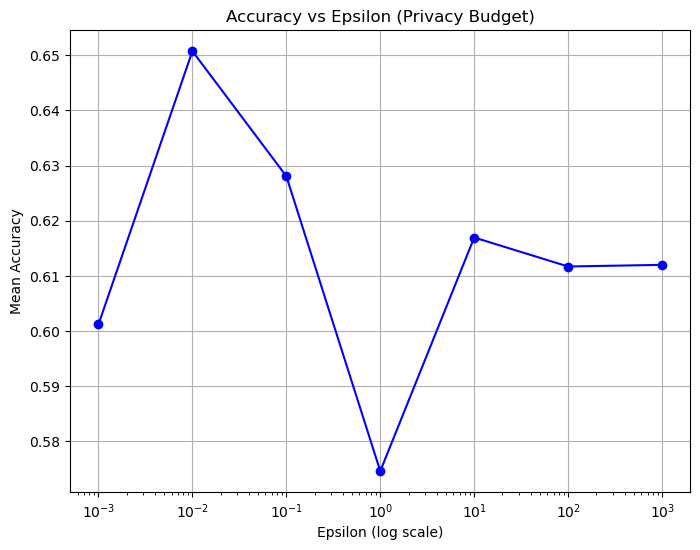

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Assuming the apply_numerical_privacy, apply_categorical_privacy, and PrivacyPreserving are already defined

# Drop rows with missing values to simplify the process
titanic_data = titanic_data.dropna()

# Define features and target
X = titanic_data[['Pclass', 'Sex', 'Age', 'Fare', 'Embarked']]
y = titanic_data['Survived']

# Define column transformer for imputing and encoding
numerical_features = ['Age', 'Fare']
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_features = ['Pclass', 'Sex', 'Embarked']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Define the preprocessor for the pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a Pipeline with the preprocessor and the classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier())
])

# Define a list of epsilon values to evaluate (logarithmic scale from 0.1 to 100)
epsilons = np.logspace(-3, 3, 7)
accuracies = []

# Loop through each epsilon value
for epsilon in epsilons:
    # Step 1: Apply privacy-preserving transformations to numerical columns
    X_priv_numerical = apply_numerical_privacy(X.copy(), numerical_features, epsilon)
    
    # Step 2: Apply privacy-preserving transformations to categorical columns
    X_priv_categorical = apply_categorical_privacy(X.copy(), categorical_features, epsilon, 'rappor_privacy')
    
    # Combine numerical and categorical transformations
    X_priv_combined = X_priv_numerical.copy()
    X_priv_combined[categorical_features] = X_priv_categorical[categorical_features]
    
    # Step 3: Apply differential privacy to the target variable (y, 'Survived')
    y_priv_df = pd.DataFrame({'Survived': y})
    y_priv = PrivacyPreserving(y_priv_df, 'Survived', epsilon).apply_privacy_method('rappor_privacy')
    y_priv = y_priv_df['Survived']  # Extract the transformed 'Survived' column after privacy

    # Step 4: Perform cross-validation and calculate accuracy
    cv_results = cross_val_score(pipeline, X_priv_combined, y_priv, cv=5, scoring='accuracy')
    accuracies.append(np.mean(cv_results))

# Step 5: Plot the accuracy for each epsilon
plt.figure(figsize=(8, 6))
plt.plot(epsilons, accuracies, marker='o', linestyle='-', color='b')
plt.xscale('log')
plt.xlabel('Epsilon (log scale)')
plt.ylabel('Mean Accuracy')
plt.title('Accuracy vs Epsilon (Privacy Budget)')
plt.grid(True)
plt.show()


### Parte Segunda. Local Privacy

In [62]:
import torch

class Normalizer:
    @staticmethod
    def normalize_to_range(vector, min_range=-1, max_range=1):
        """
        Normalize a vector of numbers to a specified range using PyTorch.

        Parameters:
        vector (list or torch.Tensor): The vector of numbers to normalize.
        min_range (float): The minimum value of the range. Default is -1.
        max_range (float): The maximum value of the range. Default is 1.

        Returns:
        torch.Tensor: The normalized vector.
        """
        vector = torch.tensor(vector, dtype=torch.float32)
        min_val = torch.min(vector)
        max_val = torch.max(vector)

        # Normalize to [0, 1]
        normalized = (vector - min_val) / (max_val - min_val)

        # Scale to [min_range, max_range]
        normalized = normalized * (max_range - min_range) + min_range

        return normalized

class AlgorithmDP:
    @staticmethod
    def duchi_solution(t_i_vector, epsilon):
        """
        Apply the Duchi et al. differential privacy solution to a vector.

        Parameters:
        t_i_vector (list or torch.Tensor): The input vector of numbers.
        epsilon (float): The privacy parameter.

        Returns:
        np.array: The transformed vector.
        """
        # Convert the input vector to a tensor
        t_i_tensor = torch.tensor(t_i_vector, dtype=torch.float32)
        
        # Ensure the input is within the range [-1, 1]
        t_i_tensor = torch.clamp(t_i_tensor, -1, 1)

        # Calculate the probabilities
        e_epsilon = torch.exp(torch.tensor(epsilon, dtype=torch.float32))
        prob = (e_epsilon - 1) / (2 * e_epsilon + 2) * t_i_tensor + 0.5

        # Sample Bernoulli variables
        u = torch.bernoulli(prob.clone().detach())

        # Calculate the output based on the values of u
        t_i_star = torch.where(u == 1, 
                               (e_epsilon + 1) / (e_epsilon - 1),
                               (1 - e_epsilon) / (e_epsilon + 1))
        
        return t_i_star.numpy()

    @staticmethod
    def piecewise_mechanism(t_i_vector, epsilon):
        """
        Apply the Piecewise Mechanism for One-Dimensional Numeric Data.

        Parameters:
        t_i_vector (list or torch.Tensor): The input vector of numbers in the range [-1, 1].
        epsilon (float): The privacy parameter.

        Returns:
        np.array: The transformed vector within the range [-C, C].
        """
        # Convert the input vector to a tensor
        t_i_tensor = torch.tensor(t_i_vector, dtype=torch.float32)
        
        # Ensure the input is within the range [-1, 1]
        t_i_tensor = torch.clamp(t_i_tensor, -1, 1)
        
        # Calculate C
        C = (torch.exp(torch.tensor(epsilon / 2)) + 1) / (torch.exp(torch.tensor(epsilon / 2)) - 1)
        
        # Define l(t_i) and r(t_i)
        def l(t_i):
            return (C + 1) / 2 * t_i - (C - 1) / 2

        def r(t_i):
            return l(t_i) + C - 1

        # Sample x uniformly at random from [0, 1]
        x = torch.rand(t_i_tensor.shape)

        # Calculate the threshold
        threshold = torch.exp(torch.tensor(epsilon / 2)) / (torch.exp(torch.tensor(epsilon / 2)) + 1)
        
        # Initialize t_i_star
        t_i_star = torch.empty(t_i_tensor.shape, dtype=torch.float32)
        
        # Compute t_i_star based on the condition
        for i in range(t_i_tensor.shape[0]):
            l_val = l(t_i_tensor[i])
            r_val = r(t_i_tensor[i])
            #print(f"t_i_tensor[{i}] = {t_i_tensor[i]}, l(t_i) = {l_val}, r(t_i) = {r_val}, C = {C}")
            
            if x[i] < threshold:
                # Ensure low < high for the uniform distribution
                if l_val >= r_val:
                    r_val = l_val + 1e-5
                # Sample t_i_star uniformly at random from [l(t_i), r(t_i)]
                t_i_star[i] = torch.distributions.Uniform(l_val, r_val).sample()
            else:
                # Sample t_i_star uniformly at random from [-C, l(t_i)) ∪ (r(t_i), C]
                if torch.rand(1) < 0.5:
                    # Ensure low < high for the uniform distribution
                    if -C >= l_val:
                        l_val = -C + 1e-5
                    t_i_star[i] = torch.distributions.Uniform(-C, l_val).sample()
                else:
                    # Ensure low < high for the uniform distribution
                    if r_val >= C:
                        r_val = C - 1e-5
                    t_i_star[i] = torch.distributions.Uniform(r_val, C).sample()

        return t_i_star.numpy()


def direct_encoding(value, category_to_index, index_to_category, d, epsilon):
    """
    Apply the direct encoding differential privacy mechanism to a categorical value.

    Parameters:
    value (str or int): The original category value.
    category_to_index (dict): Mapping from category to index.
    index_to_category (dict): Mapping from index to category.
    d (int): Number of unique categories.
    epsilon (float): Privacy parameter.

    Returns:
    str or int: The differentially private category value.
    """
    p = np.exp(epsilon) / (np.exp(epsilon) + d - 1)
    q = 1 / (np.exp(epsilon) + d - 1)
    
    probabilities = np.full(d, q)
    true_index = category_to_index[value]
    probabilities[true_index] = p
    
    privatized_index = np.random.choice(d, p=probabilities)
    return index_to_category[privatized_index]


In [63]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Assuming AlgorithmDP and Normalizer classes are defined as per your code


In [64]:
titanic_data=pd.read_csv('Titanic-Dataset.csv')
titanic_data.head()

titanic_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [65]:
#dropping unnecessary features and encoding
le=LabelEncoder()
titanic_data['Sex']=le.fit_transform(titanic_data['Sex'].astype(str))
titanic_data['Embarked']=le.fit_transform(titanic_data['Embarked'].astype(str))
titanic_data.drop(['PassengerId'],axis=1,inplace=True)
titanic_data.drop(['Name'],axis=1,inplace=True)
titanic_data.drop(['Ticket'],axis=1,inplace=True)
titanic_data.drop(['Cabin'],axis=1,inplace=True)
titanic_data.drop(['Age'],axis=1,inplace=True)
titanic_data.head()

#titanic_data.to_csv('titanic_data_clean.csv',index=False)



,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,1,1,0,7.2500,2
1,1,1,0,1,0,71.2833,0
2,1,3,0,0,0,7.9250,2
3,1,1,0,1,0,53.1000,2
4,0,3,1,0,0,8.0500,2


In [66]:
# Numerical columns
numerical_columns = ['SibSp', 'Parch', 'Fare']

# Categorical columns
categorical_columns = ['Pclass', 'Sex', 'Embarked']


In [67]:
# For numerical columns, fill missing values with the mean
for col in numerical_columns:
    titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)

# For categorical columns, fill missing values with the mode
for col in categorical_columns:
    titanic_data[col].fillna(titanic_data[col].mode()[0], inplace=True)


C:\Users\David\AppData\Local\Temp\ipykernel_33936\829217608.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_33936\829217608.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a 

In [68]:
# Initialize the Normalizer
normalizer = Normalizer()

# Normalize each numerical column
for col in numerical_columns:
    vector = titanic_data[col].values
    normalized_vector = normalizer.normalize_to_range(vector, min_range=-1, max_range=1)
    titanic_data[col] = normalized_vector


In [69]:
# Set the privacy parameter epsilon for numerical variables
epsilon_numerical = 1.0  # Adjust as needed

# Apply differential privacy to each numerical column
for col in numerical_columns:
    vector = titanic_data[col].values
    dp_vector = AlgorithmDP.duchi_solution(vector, epsilon_numerical)
    titanic_data[col] = dp_vector


In [70]:
# Set the privacy parameter epsilon for categorical variables
epsilon_categorical = 1.0  # Adjust as needed

# Apply differential privacy to categorical variables
for col in categorical_columns:
    # Get unique categories
    categories = titanic_data[col].astype(str).unique()
    d = len(categories)
    
    # Create mappings
    category_to_index = {category: idx for idx, category in enumerate(categories)}
    index_to_category = {idx: category for category, idx in category_to_index.items()}
    
    # Apply the direct_encoding function
    titanic_data[col] = titanic_data[col].apply(
        lambda x: direct_encoding(str(x), category_to_index, index_to_category, d, epsilon_categorical)
    )


In [71]:
# Initialize label encoders
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    titanic_data[col] = le.fit_transform(titanic_data[col].astype(str))
    label_encoders[col] = le


In [72]:
# Separate the target variable
Y = titanic_data['Survived']

# Drop 'Survived' from the features
X = titanic_data.drop('Survived', axis=1)


In [73]:
# Split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=0, stratify=Y
)


In [74]:
# Initialize the Random Forest Classifier
model = RandomForestClassifier(random_state=0)

# Train the model
model.fit(X_train, Y_train)


RandomForestClassifier(random_state=0)

In [76]:
# Make predictions on the test set
Y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(Y_test, Y_pred)

print("Efficiency is :")
print(f"{accuracy * 100:.2f}%")


Efficiency is :
62.01%


### Function Definition


In [1]:
def dp_random_forest_classifier(titanic_data, epsilon_numerical, epsilon_categorical):
    """
    Applies differential privacy to the Titanic dataset and trains a Random Forest classifier.
    
    Parameters:
    - titanic_data (pd.DataFrame): The Titanic dataset with necessary columns.
    - epsilon_numerical (float): Privacy parameter for numerical variables.
    - epsilon_categorical (float): Privacy parameter for categorical variables.
    
    Returns:
    - accuracy (float): Accuracy of the Random Forest classifier on the test set.
    """
    import numpy as np
    import torch
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import accuracy_score
    from sklearn.preprocessing import LabelEncoder
    
    # Identify numerical and categorical columns
    numerical_columns = ['SibSp', 'Parch', 'Fare']
    categorical_columns = ['Pclass', 'Sex', 'Embarked']
    
    # Handle missing values
    for col in numerical_columns:
        titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)
    
    for col in categorical_columns:
        titanic_data[col].fillna(titanic_data[col].mode()[0], inplace=True)
    
    # Normalize numerical variables
    class Normalizer:
        @staticmethod
        def normalize_to_range(vector, min_range=-1, max_range=1):
            vector = torch.tensor(vector, dtype=torch.float32)
            min_val = torch.min(vector)
            max_val = torch.max(vector)
            normalized = (vector - min_val) / (max_val - min_val)
            normalized = normalized * (max_range - min_range) + min_range
            return normalized.numpy()
    
    normalizer = Normalizer()
    for col in numerical_columns:
        vector = titanic_data[col].values
        normalized_vector = normalizer.normalize_to_range(vector, min_range=-1, max_range=1)
        titanic_data[col] = normalized_vector
    
    # Apply differential privacy to numerical variables
    class AlgorithmDP:
        @staticmethod
        def duchi_solution(t_i_vector, epsilon):
            t_i_tensor = torch.tensor(t_i_vector, dtype=torch.float32)
            t_i_tensor = torch.clamp(t_i_tensor, -1, 1)
            e_epsilon = torch.exp(torch.tensor(epsilon, dtype=torch.float32))
            prob = (e_epsilon - 1) / (2 * e_epsilon + 2) * t_i_tensor + 0.5
            u = torch.bernoulli(prob.clone().detach())
            t_i_star = torch.where(u == 1, 
                                   (e_epsilon + 1) / (e_epsilon - 1),
                                   (1 - e_epsilon) / (e_epsilon + 1))
            return t_i_star.numpy()
    
    for col in numerical_columns:
        vector = titanic_data[col].values
        dp_vector = AlgorithmDP.duchi_solution(vector, epsilon_numerical)
        titanic_data[col] = dp_vector
    
    # Apply differential privacy to categorical variables
    def direct_encoding(value, category_to_index, index_to_category, d, epsilon):
        p = np.exp(epsilon) / (np.exp(epsilon) + d - 1)
        q = 1 / (np.exp(epsilon) + d - 1)
        probabilities = np.full(d, q)
        true_index = category_to_index[value]
        probabilities[true_index] = p
        privatized_index = np.random.choice(d, p=probabilities)
        return index_to_category[privatized_index]
    
    for col in categorical_columns:
        categories = titanic_data[col].astype(str).unique()
        d = len(categories)
        category_to_index = {category: idx for idx, category in enumerate(categories)}
        index_to_category = {idx: category for category, idx in category_to_index.items()}
        titanic_data[col] = titanic_data[col].apply(
            lambda x: direct_encoding(str(x), category_to_index, index_to_category, d, epsilon_categorical)
        )
    
    # Encode categorical variables to numerical format
    for col in categorical_columns:
        le = LabelEncoder()
        titanic_data[col] = le.fit_transform(titanic_data[col].astype(str))
    
    # Separate features and target variable
    Y = titanic_data['Survived']
    X = titanic_data.drop('Survived', axis=1)
    
    # Split the dataset
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.2, random_state=0, stratify=Y
    )
    
    # Train the Random Forest Classifier
    model = RandomForestClassifier(random_state=0)
    model.fit(X_train, Y_train)
    
    # Make predictions and evaluate the model
    Y_pred = model.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_pred)
    print(f"Accuracy with ε_numerical={epsilon_numerical}, ε_categorical={epsilon_categorical}: {accuracy * 100:.2f}%")
    
    return accuracy


In [2]:
import pandas as pd

# Load your dataset
titanic_data = pd.read_csv('titanic_data_clean.csv')


Testing with epsilon = 0.005
Accuracy with ε_numerical=0.005, ε_categorical=0.005: 59.78%
Testing with epsilon = 0.007338996338110349
Accuracy with ε_numerical=0.007338996338110349, ε_categorical=0.007338996338110349: 58.10%
Testing with epsilon = 0.010772173450159416
Accuracy with ε_numerical=0.010772173450159416, ε_categorical=0.010772173450159416: 54.19%
Testing with epsilon = 0.015811388300841896
Accuracy with ε_numerical=0.015811388300841896, ε_categorical=0.015811388300841896: 49.16%
Testing with epsilon = 0.023207944168063887
Accuracy with ε_numerical=0.023207944168063887, ε_categorical=0.023207944168063887: 52.51%
Testing with epsilon = 0.03406460345289806
Accuracy with ε_numerical=0.03406460345289806, ε_categorical=0.03406460345289806: 51.96%
Testing with epsilon = 0.05
Accuracy with ε_numerical=0.05, ε_categorical=0.05: 52.51%
Testing with epsilon = 0.07338996338110346
Accuracy with ε_numerical=0.07338996338110346, ε_categorical=0.07338996338110346: 50.28%
Testing with epsilo

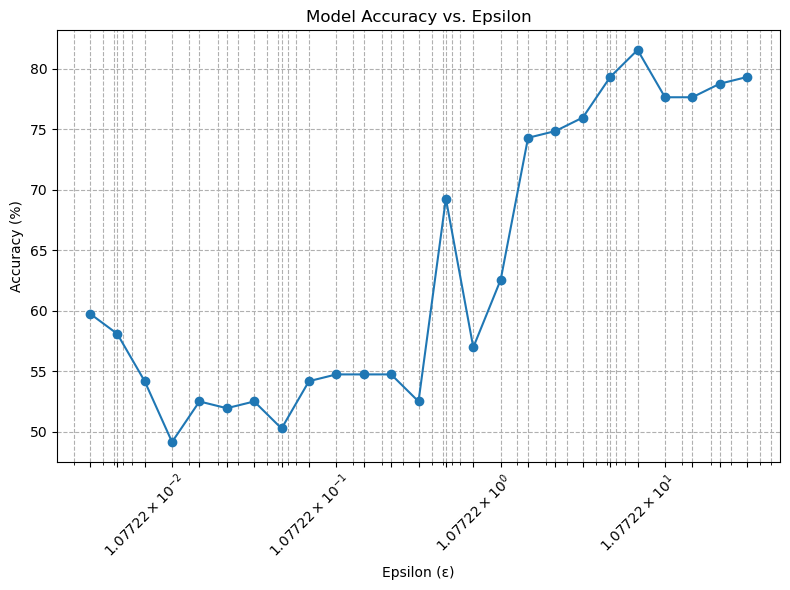

: 

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Define epsilon values to test using a logarithmic scale
epsilon_values = np.logspace(-2, 2, 25) * 0.5

# Assuming dp_random_forest_classifier function and titanic_data exist and return accuracy values
# Store accuracies for plotting
results = []

for eps in epsilon_values:
    print(f"Testing with epsilon = {eps}")
    accuracy = dp_random_forest_classifier(titanic_data.copy(), eps, eps)  # Update with actual function
    results.append({'epsilon': eps, 'accuracy': accuracy})

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Plot Accuracy vs. Epsilon with a logarithmic scale on the x-axis
plt.figure(figsize=(8, 6))
plt.plot(results_df['epsilon'], results_df['accuracy'] * 100, marker='o')
plt.xscale('log')  # Set x-axis to log scale
plt.title('Model Accuracy vs. Epsilon')
plt.xlabel('Epsilon (ε)')
plt.ylabel('Accuracy (%)')
plt.xticks(epsilon_values, rotation=45)
plt.grid(True, which="both", ls="--")  # Enable grid for both axes
plt.tight_layout()
plt.show()



Testing with epsilon = 0.005
Accuracy with ε_numerical=0.005, ε_categorical=0.005: 56.42%
Testing with epsilon = 0.007338996338110349
Accuracy with ε_numerical=0.007338996338110349, ε_categorical=0.007338996338110349: 54.19%
Testing with epsilon = 0.010772173450159416
Accuracy with ε_numerical=0.010772173450159416, ε_categorical=0.010772173450159416: 58.10%
Testing with epsilon = 0.015811388300841896
Accuracy with ε_numerical=0.015811388300841896, ε_categorical=0.015811388300841896: 51.96%
Testing with epsilon = 0.023207944168063887
Accuracy with ε_numerical=0.023207944168063887, ε_categorical=0.023207944168063887: 52.51%
Testing with epsilon = 0.03406460345289806
Accuracy with ε_numerical=0.03406460345289806, ε_categorical=0.03406460345289806: 48.04%
Testing with epsilon = 0.05
Accuracy with ε_numerical=0.05, ε_categorical=0.05: 51.40%
Testing with epsilon = 0.07338996338110346
Accuracy with ε_numerical=0.07338996338110346, ε_categorical=0.07338996338110346: 52.51%
Testing with epsilo

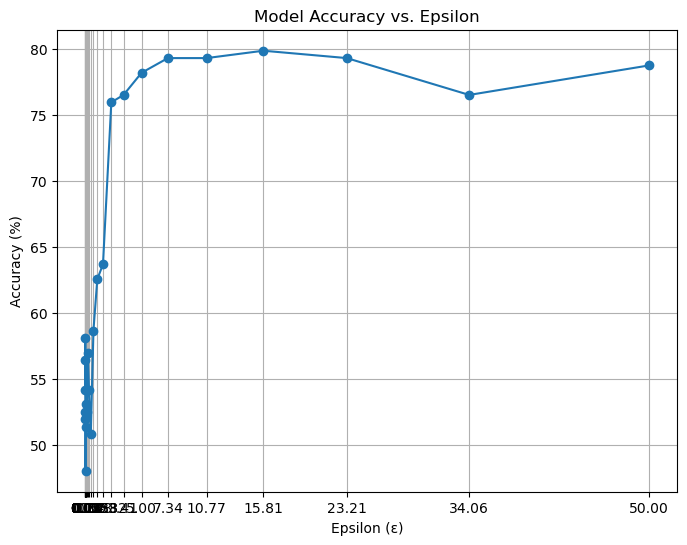